In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays
from IPython.core.debugger import set_trace

import utils

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [5]:
from tqdm import tqdm_notebook
import collections

In [6]:
class IndexMap():
    """
    Class that maps objects to unique integer indices and back.
    
    Args:
        arrays: One or more arrays that contain the objects (in any order and with duplicates).
        start_index (int): Start the mapped indices here.
    """
    
    def __init__(self, *arrays, **kwargs):
        self.start_index = kwargs.get('start_index', 0)
        unique_values = np.unique(np.concatenate([np.unique(array) for array in arrays]))
        self._index_to_value = dict(enumerate(unique_values, self.start_index))
        self._value_to_index = utils.invert_dict(self._index_to_value)
        
    def from_index(self, index):
        return self._index_to_value[index]
    
    def to_index(self, value):
        return self._value_to_index[value]
    
    def __len__(self):
        return len(self._index_to_value)
  
    def __repr__(self):
        return 'IndexMap ({} unique objects, starting at {})'.format(len(self), self.start_index)

In [7]:
def plot_matrix(m):
    plt.imshow(m, cmap='Greys', interpolation=None)

# Datasets and Preprocessing

## FB15K-237

In [7]:
%%bash

# Download and unzip FB15K-237.
#cd data
#mkdir fb15k-237
#cd fb15k-237
#wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
#unzip FB15K-237.2.zip

In [8]:
BASE_DIR = 'data/fb15k-237/Release/'
TRAIN_FILE = BASE_DIR + 'train.txt'
TEST_FILE = BASE_DIR + 'test.txt'
VAL_FILE = BASE_DIR + 'valid.txt'

In [9]:
train_triples = pd.read_csv(TRAIN_FILE, sep='\t', names=['subject', 'relation', 'object'])
val_triples = pd.read_csv(VAL_FILE, sep='\t', names=['subject', 'relation', 'object'])
test_triples = pd.read_csv(TEST_FILE, sep='\t', names=['subject', 'relation', 'object'])
print(len(train_triples), len(val_triples), len(test_triples))
train_triples.head()

272115 17535 20466


,subject,relation,object
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [10]:
entity_map = IndexMap(train_triples[['subject', 'object']].values, 
                      val_triples[['subject', 'object']].values, 
                      test_triples[['subject', 'object']].values)

In [47]:
num_nodes = len(enitity_map)
num_nodes

2625

In [50]:
num_feats = num_nodes
feat_data = np.eye(num_nodes)

In [51]:
num_classes = 5
# TODO: Random labels don't work here. Find some labels that make sense.
labels = np.random.randint(num_classes, size=num_nodes).reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [52]:
# TODO: Make this faster.
adj_lists = collections.defaultdict(set)
for i, row in tqdm_notebook(train_triples.iterrows(), total=len(train_triples)):
    subject_index = entity_map.to_index(row['subject'])
    object_index = entity_map.to_index(row['object'])
    # Use non-directed edges here.
    adj_lists[subject_index].add(object_index)
    adj_lists[object_index].add(subject_index)

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

## FB15K-237: Numbers (Garcia-Duran et al. 2017)

In [49]:
%%bash

# Download numerical data from Garcia-Duran et al. (2017).
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/nle-ml/mmkb/master/numTriples_FB15k.txt

In [47]:
numerical_features = pd.read_csv('data/fb15k-237/numTriples_FB15k.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features.head()

,entity,attribute,value
0,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,9.704049e+00
1,/m/06rf7,<http://rdf.freebase.com/ns/location.geocode.l...,5.420868e+01
2,/m/06rf7,<http://rdf.freebase.com/ns/topic_server.popul...,2.837021e+06
3,/m/06rf7,<http://rdf.freebase.com/ns/location.location....,1.576318e+04
4,/m/04258w,<http://rdf.freebase.com/ns/people.person.date...,1.912667e+03


In [46]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 12493
Intersection (entities in train set with numerical features): 12047


## FB15K-237: Numbers and texts (Kristiadi et al. 2018)

In [52]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt

--2018-03-05 14:44:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/numerical_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196154 (5.0M) [text/plain]
Saving to: 'numerical_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 3.99M 1s
    50K .......... .......... .......... .......... ..........  1% 7.02M 1s
   100K .......... .......... .......... .......... ..........  2% 6.95M 1s
   150K .......... .......... .......... .......... ..........  3% 7.05M 1s
   200K .......... .......... .......... .......... ..........  4% 7.89M 1s
   250K .......... .......... .......... .......... ..........  5% 8.27M 1s
   300K .......... .......... .......... .......... ..........  6% 10.7M 1s
   350K .......... ....

In [53]:
numerical_features_kristiadi = pd.read_csv('data/fb15k-237/numerical_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
numerical_features_kristiadi.head()

,entity,attribute,value
0,/m/0265wl,http://rdf.freebase.com/ns/award.award_categor...,1965
1,/m/0n5c9,http://rdf.freebase.com/ns/location.location.area,1245.78428107
2,/m/0n5c9,http://rdf.freebase.com/ns/location.dated_loca...,1739
3,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,462263
4,/m/0n5c9,http://rdf.freebase.com/ns/topic_server.popula...,482155


In [54]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with numerical features:', len(numerical_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with numerical features):', len(np.intersect1d(numerical_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with numerical features: 9941
Intersection (entities in train set with numerical features): 9608


In [55]:
%%bash
#cd data/fb15k-237
#wget https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt

--2018-03-05 14:46:55--  https://raw.githubusercontent.com/SmartDataAnalytics/LiteralE/master/data/FB15k-237/literals/text_literals.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12991982 (12M) [text/plain]
Saving to: 'text_literals.txt'

     0K .......... .......... .......... .......... ..........  0% 1.24M 10s
    50K .......... .......... .......... .......... ..........  0% 4.23M 6s
   100K .......... .......... .......... .......... ..........  1% 6.51M 5s
   150K .......... .......... .......... .......... ..........  1% 6.65M 4s
   200K .......... .......... .......... .......... ..........  1% 7.22M 4s
   250K .......... .......... .......... .......... ..........  2% 10.1M 3s
   300K .......... .......... .......... .......... ..........  2% 8.66M 3s
   350K .......... .......... ..

In [56]:
text_features_kristiadi = pd.read_csv('data/fb15k-237/text_literals.txt', sep='\t', names=['entity', 'attribute', 'value'])
text_features_kristiadi.head()

,entity,attribute,value
0,/m/03j9ml,http://rdf.freebase.com/ns/common.topic.descri...,Maggie Roswell is an American film and televis...
1,/m/05cws2,http://rdf.freebase.com/ns/common.topic.descri...,Halesowen Town is an English association footb...
2,/m/0qxzd,http://rdf.freebase.com/ns/common.topic.descri...,"Hayward is a city located in Alameda County, C..."
3,/m/01h18v,http://rdf.freebase.com/ns/common.topic.descri...,About Schmidt is a 2002 American comedy-drama ...
4,/m/0c4y8,http://rdf.freebase.com/ns/common.topic.descri...,"Thomas Lanier ""Tennessee"" Williams III was an ..."


In [59]:
print('Entities in train set:', len(train_triples['subject'].unique()))
print('Entities with text features:', len(text_features_kristiadi['entity'].unique()))
print('Intersection (entities in train set with text features):', len(np.intersect1d(text_features_kristiadi['entity'].unique(), train_triples['subject'].unique())))

Entities in train set: 13781
Entities with text features: 14886
Intersection (entities in train set with text features): 13754


## FB15K-237: Images (ImageGraph; Onoro-Rubio et al. 2017)

In [92]:
%%bash
#cd data/fb15k-237
#wget https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
#tar -xvzf image-graph_urls.tar.gz

--2018-03-12 14:04:52--  https://www.dropbox.com/s/thct96phmypkaon/image-graph_urls.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file [following]
--2018-03-12 14:04:52--  https://dl.dropboxusercontent.com/content_link/ct8mncZqLggve46aNBpGZJ3KEH93mLyB6cpivrWAZImNFpywuiCyOlVYZn5HDjXT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95528096 (91M) [application/octet-stream]
Saving to: 'image-graph_urls.tar.gz'

     0K .......... .......... .......... .......... ..........  0%  633K 2m27s
    50K .......... .......... .......... ...

In [164]:
# Download images via script `donwload-images.py`

## YAGO3-10

In [ ]:
# TODO

## MovieLens-100k

In [29]:
%%bash
#cd data
#mkdir movielens-100k
#wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
#unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


--2018-03-08 01:22:47--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

     0K .......... .......... .......... .......... ..........  1%  228K 21s
    50K .......... .......... .......... .......... ..........  2%  460K 15s
   100K .......... .......... .......... .......... ..........  3% 5.27M 10s
   150K .......... .......... .......... .......... ..........  4% 7.53M 8s
   200K .......... .......... .......... .......... ..........  5%  494K 8s
   250K .......... .......... .......... .......... ..........  6% 4.55M 7s
   300K .......... .......... .......... .......... ..........  7%  511K 7s
   350K .......... .......... .......... .......... ..........  8% 7.69M 6s
   400K .......... .......... ...

In [8]:
# TODO: Do not use complete dataset here, but one of the official splits.
triples = pd.read_csv('../data/movielens-100k/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
triples.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
user_map = IndexMap(triples['user_id'])
item_map = IndexMap(triples['item_id'], start_index=len(user_map))

In [10]:
num_nodes = len(user_map) + len(item_map)
num_nodes

2625

In [11]:
num_feats = num_nodes
feat_data = np.eye(num_nodes)

In [12]:
num_classes = 2
labels = np.zeros(num_nodes)
labels[:len(user_map)] = 1
labels = labels.reshape(-1, 1)
labels

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [13]:
# TODO: Make this faster.
adj_lists = collections.defaultdict(set)
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    # Use non-directed edges here.
    adj_lists[user_index].add(item_index)
    adj_lists[item_index].add(user_index)

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

In [14]:
# Relational approach.
rating_map = IndexMap(triples['rating'])
num_relations = len(rating_map)

adj_lists_per_relation = collections.defaultdict(lambda: collections.defaultdict(set))
for i, row in tqdm_notebook(triples.iterrows(), total=len(triples)):
    user_index = user_map.to_index(row['user_id'])
    item_index = item_map.to_index(row['item_id'])
    rating_index = rating_map.to_index(row['rating'])
    
    # Use non-directed edges here.
    adj_lists_per_relation[rating_index][user_index].add(item_index)
    adj_lists_per_relation[rating_index][item_index].add(user_index)

HBox(children=(IntProgress(value=0, max=100000), HTML(value=u'')))

## MovieLens-100k: Metadata (included with original dataset)

In [86]:
from keras.utils import to_categorical

In [90]:
movies = pd.read_csv('data/movielens-100k/ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [91]:
users = pd.read_csv('data/movielens-100k/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# TODO: How to encode those features? Movies and users have inherently different features/feature vectors!?

## MovieLens-100k: Images (Pezheskpour et al. 2017)

Download manually from https://github.com/pouyapez/multim-kb-embeddings/tree/master/datasets/Movielens-100k%20plus

Unpack into `data/movielens-100k/image`

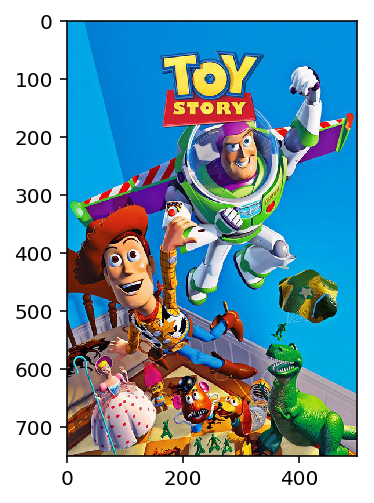

In [79]:
plt.imshow(plt.imread('data/movielens-100k/image/1.jpg'))

## Cora

In [ ]:
from graphsage.model import load_cora

In [ ]:
feat_data, labels, adj_lists = load_cora()
num_nodes, num_feats = feat_data.shape
num_classes = len(np.unique(labels))

num_nodes, num_feats, num_classes

In [ ]:
# Optional: Remove features and use identity matrix instead. 
# Set learning rate to 10 for this.
feat_data = np.eye(num_nodes)
num_feats = num_nodes

num_nodes, num_feats, num_classes

# Toy Implementation of GCN

In [132]:
# Load connections in the graph.
citations = pd.read_csv('data/cora/cora.cites', sep='\t', names=['cited', 'citing'])
citations.head()

,cited,citing
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [144]:
index_to_entity = dict(enumerate(np.unique(citations.values.flatten())))
entity_to_index = utils.invert_dict(index_to_entity)

In [191]:
num_nodes = len(index_to_entity)
num_nodes

2708

In [186]:
# Load labels for nodes.
labels = pd.read_csv('data/cora/cora.content', sep='\t', usecols=[0, 1434], names=['entity', 'label'])
labels.head()

,entity,label
0,31336,Neural_Networks
1,1061127,Rule_Learning
2,1106406,Reinforcement_Learning
3,13195,Reinforcement_Learning
4,37879,Probabilistic_Methods


In [188]:
index_to_label = dict(enumerate(labels['label'].unique()))
label_to_index = utils.invert_dict(index_to_label)

In [190]:
num_labels = len(index_to_label)
num_labels

7

5429.0

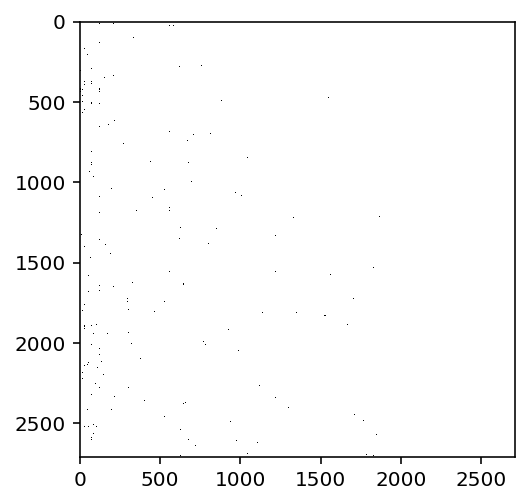

In [197]:
# Create adjacency matrix.
adj = np.zeros((num_nodes, num_nodes))

for i, row in citations.iterrows():
    adj[entity_to_index[row['citing']], entity_to_index[row['cited']]] = 1

plot_matrix(adj)
adj.sum()

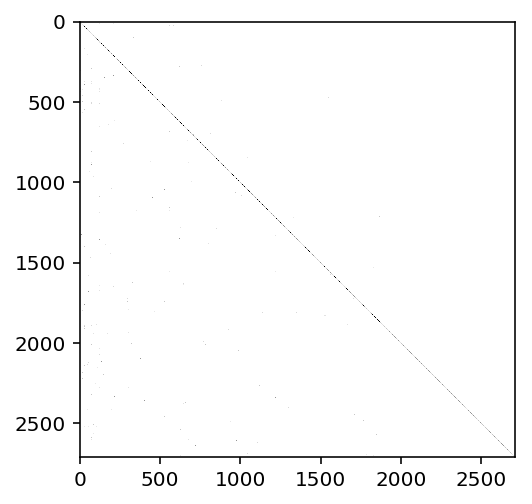

In [157]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.sparse.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

adj_transformed = normalize(adj + np.eye(num_nodes))
plot_matrix(adj_transformed)

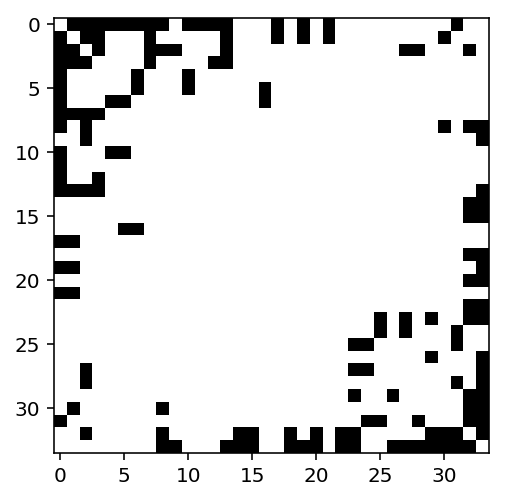

In [68]:
adj = nx.to_numpy_array(G)
plot_matrix(adj)

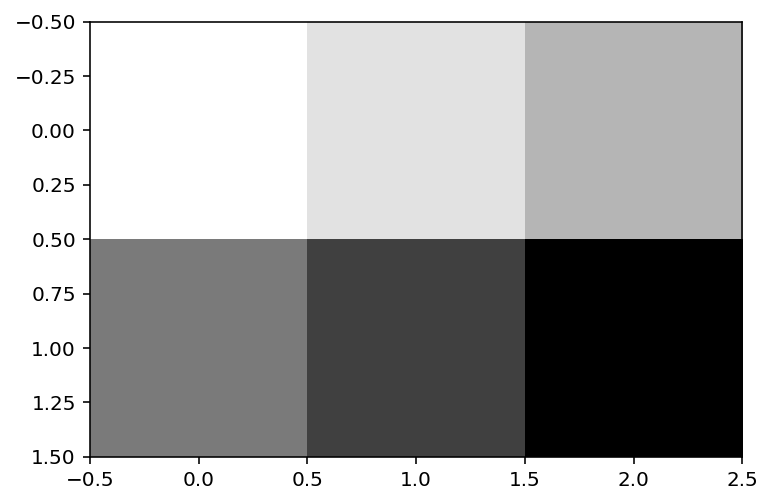

In [94]:
a = np.array([[1, 2, 3], [4, 5, 6]])
plot_matrix(a)

In [95]:
a.sum(0)

array([5, 7, 9])

In [106]:
num_nodes = len(adj)
num_classes = 7

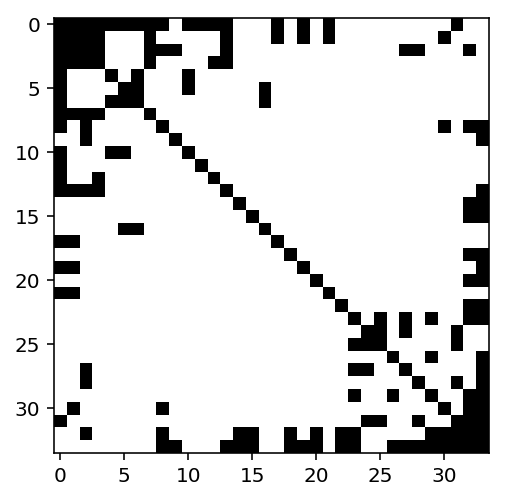

In [107]:
plot_matrix(adj + np.eye(num_nodes))

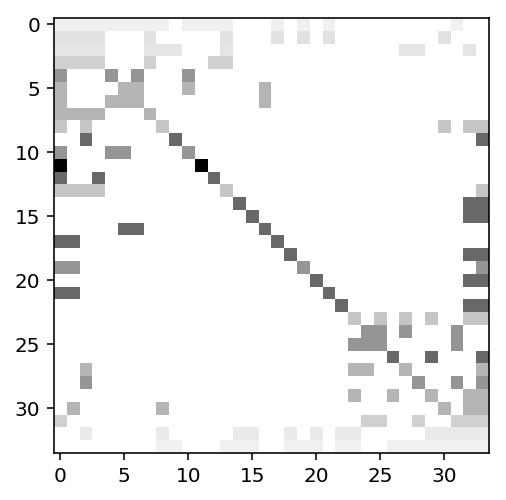

In [109]:
plot_matrix(normalize(adj + np.eye(num_nodes)))

In [110]:
import torch
from torch import nn
from torch.autograd import Variable

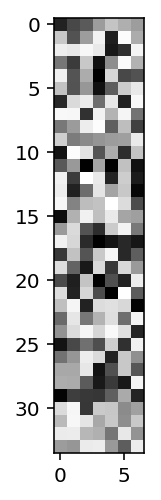

In [111]:
weight = nn.Parameter(torch.Tensor(num_nodes, num_classes), requires_grad=True)

# Initialization.
stdv = 1. / np.sqrt(weight.size(1))
weight.data.uniform_(-stdv, stdv)

plot_matrix(weight.data.numpy())

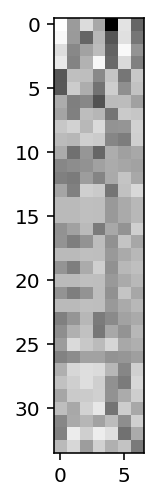

In [112]:
adj_tensor = Variable(torch.Tensor(adj), requires_grad=False)
input_features = Variable(torch.eye(num_nodes), requires_grad=False)


x = torch.mm(input_features, weight)
x = torch.mm(adj_tensor, x)
plot_matrix(x.data.numpy())

In [215]:
class GCN(nn.Module):
    
    def __init__(self, num_nodes, num_classes):
        super(GCN, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(num_nodes, num_classes))
        
        # Initialization.
        stdv = 1. / np.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        
    def forward(self, input_features, adjacency_matrix):
        x = torch.mm(input_features, self.weight)
        x = torch.mm(adjacency_matrix, x)
        return x
    
net = GCN(num_nodes, num_labels)

In [216]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [217]:
adj_tensor = Variable(torch.Tensor(adj), requires_grad=False)
input_features = Variable(torch.eye(num_nodes), requires_grad=False)

net(input_features, adj_tensor)

Variable containing:
 0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
 6.3059e+22  6.8834e-22  2.9427e-44  ...   2.9427e-44  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
                ...                   ⋱                   ...                
 0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
 6.4898e-31  2.6742e-30  3.9177e-32  ...   2.0617e-24  1.7378e-31  6.0057e-20
 2.6434e-30  4.5843e-30  3.1869e-30  ...   1.3004e-20  4.3568e-30  7.8386e-33
[torch.FloatTensor of size 2708x7]

In [207]:
net.weight.shape

torch.Size([2708, 7])

In [202]:
num_labels

7

# GraphSAGE

In [215]:
from graphsage.encoders import Encoder, RelationalEncoder
from graphsage.aggregators import MeanAggregator
from graphsage.model import SupervisedGraphSage

In [15]:
import random
import time
import math
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

## v1: Mostly original GraphSAGE code

In [55]:
# DEPRECATED. Old version following graphsage implementation.

import random
import time
from sklearn.metrics import f1_score

# Run algorithm.
np.random.seed(1)
random.seed(1)

features = nn.Embedding(num_nodes, num_feats)
features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
# features.cuda()

agg1 = MeanAggregator(features, gcn=True, cuda=False)
enc1 = Encoder(features, num_feats, 128, adj_lists, agg1, gcn=True, cuda=False)
agg2 = MeanAggregator(lambda nodes : enc1(nodes).t(), gcn=True, cuda=False)
enc2 = Encoder(lambda nodes : enc1(nodes).t(), enc1.embed_dim, 128, adj_lists, agg2,
        base_model=enc1, gcn=True, cuda=False)
#enc1.num_samples = 5
#enc2.num_samples = 5

graphsage = SupervisedGraphSage(num_classes, enc2)
#    graphsage.cuda()
rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:1000]
val = rand_indices[1000:1500]
train = list(rand_indices[1500:])

optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, graphsage.parameters()), lr=2)

In [56]:
len(train), len(val), len(test)

(1125, 500, 1000)

In [57]:
times = []
for batch in range(100):
    batch_nodes = train[:256]
    #print(batch_nodes[:5])
    random.shuffle(train)
    start_time = time.time()
    optimizer.zero_grad()
    # TODO: Define loss in here and do graphsage(batch_nodes)
    loss = graphsage.loss(batch_nodes, 
            Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
    loss.backward()
    optimizer.step()
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])

val_output = graphsage.forward(val) 
print("Validation F1:", f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro"))
print("Average batch time:", np.mean(times))

0 0.69216966629
1 0.692487955093
2 0.692568957806
3 0.691670536995
4 0.691948413849
5 0.691405057907
6 0.691282272339
7 0.690776228905
8 0.690484941006
9 0.690209448338
10 0.689939081669
11 0.689946174622
12 0.689113974571
13 0.688898205757
14 0.688425242901
15 0.687419831753
16 0.688665151596
17 0.687200844288
18 0.686179995537
19 0.685176610947
20 0.686286330223
21 0.685625314713
22 0.686039030552
23 0.682239532471
24 0.683207690716
25 0.68303668499
26 0.68181425333
27 0.682120144367
28 0.681687176228
29 0.678056120872
30 0.680051445961
31 0.678257882595
32 0.677268505096
33 0.678131341934
34 0.673082232475
35 0.673930644989
36 0.672621905804
37 0.671572625637
38 0.67493647337
39 0.664276957512
40 0.665908515453
41 0.660656750202
42 0.668606698513
43 0.656870901585
44 0.651512444019
45 0.653829872608
46 0.656028866768
47 0.644822955132
48 0.645153462887
49 0.644469380379
50 0.631398737431
51 0.611798524857
52 0.618593156338
53 0.621629953384
54 0.624132931232
55 0.610576033592
56 0.5

## v2: A bit more adapted to pytorch

In [220]:
class GraphSageClassification(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        #super(SupervisedGraphSage, self).__init__()
        # Workaround to make this work with autoreload.
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        self.features = nn.Embedding(num_nodes, num_features)
        self.features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.agg1 = MeanAggregator(self.features, gcn=True, cuda=False)
        self.enc1 = Encoder(self.features, num_features, 128, adj_lists, self.agg1, gcn=True, cuda=False)
        self.agg2 = MeanAggregator(self.enc1, gcn=True, cuda=False)
        self.enc2 = Encoder(self.enc1, self.enc1.embed_dim, 128, adj_lists, self.agg2, gcn=True, cuda=False)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(self.enc2.embed_dim, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        #embedded_features = self.enc1(nodes, self.features)
        #embedded_features = self.enc2(nodes, embedded_features)
        embeds = self.enc2(nodes)
        #print(embeds.shape)
        # TODO: Why do we need to transpose here?
        scores = self.dense(embeds)
        return scores


In [221]:
import random
import time
from sklearn.metrics import f1_score

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = GraphSageClassification(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:1000]
val = rand_indices[1000:1500]
train = list(rand_indices[1500:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=2)

times = []
for batch in range(100):
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro"))
     

print("Average batch time:", np.mean(times))

0 0.69277048111
Validation Accuracy: 0.668
Validation F1: 0.668
1 0.692744612694
2 0.692559540272
3 0.69225269556
4 0.692083060741
5 0.691838622093
6 0.691770970821
7 0.691573739052
8 0.691343128681
9 0.690978825092
10 0.690743029118
Validation Accuracy: 0.93
Validation F1: 0.93
11 0.69058907032
12 0.690448343754
13 0.690141439438
14 0.689745783806
15 0.689677476883
16 0.689437806606
17 0.688650608063
18 0.688704371452
19 0.688582479954
20 0.687926709652
Validation Accuracy: 0.962
Validation F1: 0.962
21 0.687525510788
22 0.687258720398
23 0.686985611916
24 0.686483561993
25 0.685679554939
26 0.68514251709
27 0.684846758842
28 0.683468222618
29 0.683398962021
30 0.682260394096
Validation Accuracy: 0.974
Validation F1: 0.974
31 0.681590020657
32 0.680318951607
33 0.679334700108
34 0.677971601486
35 0.67584168911
36 0.674067020416
37 0.672478616238
38 0.671090483665
39 0.670112431049
40 0.664693117142
Validation Accuracy: 0.958
Validation F1: 0.958


KeyboardInterrupt: 

## v2r: Relational version based on v2

In [176]:
# Relational version.
class GraphSageClassification(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        #super(SupervisedGraphSage, self).__init__()
        # Workaround to make this work with autoreload.
        nn.Module.__init__(self)
        
        num_nodes, num_feats = feat_data.shape
        
        self.features = nn.Embedding(num_nodes, num_feats)
        self.features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        #self.features = Variable(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.agg1 = MeanAggregator(self.features, gcn=True, cuda=False)
        self.enc1 = RelationalEncoder(self.features, num_feats, 128, adj_lists_per_relation, self.agg1, gcn=True, cuda=False)
        self.agg2 = MeanAggregator(lambda nodes : self.enc1(nodes).t(), gcn=True, cuda=False)
        self.enc2 = RelationalEncoder(lambda nodes : self.enc1(nodes).t(), self.enc1.embed_dim, 128, adj_lists_per_relation, self.agg2, gcn=True, cuda=False)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(self.enc2.embed_dim, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)


    def forward(self, nodes):
        #embedded_features = self.enc1(nodes, self.features)
        #embedded_features = self.enc2(nodes, embedded_features)
        embeds = self.enc2(nodes)
        # TODO: Why do we need to transpose here?
        scores = self.dense(embeds.t())
        return scores


In [177]:
import random
import time
from sklearn.metrics import f1_score, accuracy_score

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = GraphSageClassification(num_classes, feat_data, adj_lists_per_relation)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:1000]
val = rand_indices[1000:1500]
train = list(rand_indices[1500:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=2)

times = []
for batch in range(100):
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        #print(val_output.data.numpy())
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro"))
        
print("Average batch time:", np.mean(times))

0 0.711808741093
Validation Accuracy (sklearn): 0.628
Validation F1: 0.628
1 0.682594299316
2 0.66046744585
3 0.64946103096
4 0.642101824284
5 0.63143324852
6 0.621720671654
7 0.622435033321
8 0.616884469986
9 0.610323786736
10 0.587163984776
Validation Accuracy (sklearn): 0.65
Validation F1: 0.65
11 0.577636241913
12 0.591201007366
13 0.559204339981
14 0.535029530525
15 0.494893163443
16 0.518779695034
17 0.492399692535
18 0.502187013626
19 0.493626505136
20 0.490079283714
Validation Accuracy (sklearn): 0.652
Validation F1: 0.652
21 0.466648250818
22 0.418201088905
23 0.420033365488
24 0.419609904289
25 0.437832266092
26 0.376755148172
27 0.380629688501
28 0.352204829454
29 0.322499096394
30 0.31055572629
Validation Accuracy (sklearn): 0.804
Validation F1: 0.804
31 0.268828958273
32 0.287284582853
33 0.26244828105
34 0.229779928923
35 0.218515723944
36 0.201247856021
37 0.186405688524
38 0.161571934819
39 0.149567335844
40 0.147314369678
Validation Accuracy (sklearn): 0.936
Validation

## v3: Re-implementation (non-relational)

In [16]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, in_features_func, adj_lists, num_sample=10, activation=F.relu):
        nn.Module.__init__(self)
        self.in_features = in_features
        self.out_features = out_features
        self.in_features_func = in_features_func
        self.adj_lists = adj_lists
        self.num_sample = num_sample
        self.activation = activation
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform(self.weight)
        
        
    def aggregate(self, nodes, adj_lists, include_self=False):
        """Return a vector for each node in `nodes` by mean-aggregating feature vectors from its neighborhood (or a sample thereof)."""
        sampled_neighbors_per_node = [adj_lists[node] for node in nodes]
        
        # TODO: Check if this improves the network
        #       Also, in graphsage, this is done after the sampling step (which doesn't make much sense though).
        if include_self:
            for sampled_neighbors, node in zip(sampled_neighbors_per_node, nodes):
                sampled_neighbors.add(node)
        
        if self.num_sample is not None:
            # TODO: See if local pointers bring speed improvements.
            for i in range(len(sampled_neighbors_per_node)):
                if self.num_sample <= len(sampled_neighbors_per_node[i]):
                    sampled_neighbors_per_node[i] = set(random.sample(sampled_neighbors_per_node[i], self.num_sample))
            
        # TODO: See if I can improve the code from here on.
        # TODO: Rename to unique_neighbors.
        unique_neighbors = list(set.union(*sampled_neighbors_per_node))
        unique_neighbors_to_index = {neighbor: i for i, neighbor in enumerate(unique_neighbors)}
        
        if unique_neighbors:

            # TODO: Check if this really needs to be a variable.
            # TODO: Maybe store mask in self and fill it with zeros here.
            mask = Variable(torch.zeros(len(nodes), len(unique_neighbors)), requires_grad=False)
            if self.is_cuda():
                mask = mask.cuda()
            # TODO: Understand and rename variables here.
            column_indices = [unique_neighbors_to_index[neighbor] for sampled_neighbors in sampled_neighbors_per_node for neighbor in sampled_neighbors]
            row_indices = [i for i in range(len(sampled_neighbors_per_node)) for j in range(len(sampled_neighbors_per_node[i]))]
            mask[row_indices, column_indices] = 1
            #plot_matrix(mask)

            num_neighbors = mask.sum(1, keepdim=True)
            mask /= num_neighbors + 1e-10  # prevent zero division

            #print(unique_neighbors)
            unique_neighbors_tensor = torch.LongTensor(unique_neighbors)
            if self.is_cuda():
                unique_neighbors_tensor = unique_neighbors_tensor.cuda()
            f = self.in_features_func(unique_neighbors_tensor)
            
            #print(len(nodes))
            #print(len(unique_neighbors_list))
            #print(mask.mm(f).shape)
            
            return mask.mm(f)
        else:
            # TODO: If there are no neighbors, this currently returns a zero vector. Is this correct?
            zeros = Variable(torch.zeros(len(nodes), self.in_features), requires_grad=False)
            if self.is_cuda():
                zeros = zeros.cuda()
            return zeros

        
    def forward(self, nodes):
        neighborhood_features = self.aggregate(nodes, self.adj_lists, include_self=True)
        
        # TODO: Maybe add features of nodes themselves,
        #       or include nodes themselves in sampling process in aggregate function (as in GraphSAGE,
        #       but collides with RGCN use of aggregate function).
        #node_features = self.in_features_func(torch.LongTensor(nodes))
        
        return self.activation(neighborhood_features.mm(self.weight.t()))
    
    def is_cuda(self):
        return self.weight.is_cuda
    

In [15]:
class SupervisedGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = GraphConvolution(num_features, 128, features, adj_lists, activation=F.relu)
        self.graph_conv2 = GraphConvolution(128, 128, self.graph_conv1, adj_lists, activation=F.relu)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        scores = self.dense(node_embeddings)
        return scores

In [16]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedGCN(num_classes, feat_data, adj_lists)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU.')
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    batch_nodes = train[:256]
    random.shuffle(train)
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Moving network to GPU.
0 0.693477869034
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.18216204643249512
1 0.66594684124
2 0.611563622952
3 0.528999328613
4 0.428273051977
5 0.311464399099
6 0.225795477629
7 0.197728142142
8 0.132967710495
9 0.103745773435
10 0.0680298507214
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.05631990866227583
11 0.0422809645534
12 0.0188495069742
13 0.00856670364738
14 0.00584590388462
15 0.00157861132175
16 0.000716699287295
17 0.000296247191727
18 0.000113040208817
19 6.23865053058e-05
20 2.50544399023e-05
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.05277629125685919
21 6.59376382828e-06
22 2.73007899523e-05
23 2.57231295109e-06
24 8.43778252602e-07
25 6.55651092529e-07
26 2.08616256714e-07
27 2.421438694e-07
28 1.60187482834e-07
29 5.64381480217e-07
30 1.07474625111e-06
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.05500421216410975
31 1.06170773506e-07
32 6.92903995514e

In [174]:
# Alternative version with epochs and progressbar.
# TODO: Update CUDA support.

from tqdm import tqdm

# Run algorithm.
np.random.seed(1)
random.seed(1)

net = SupervisedGCN(num_classes, feat_data, adj_lists)
#    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

num_epochs = 10
batch_size = 256

for epoch in range(1, num_epochs+1):
    
    
    #tqdm.write('Epoch {}/{}:'.format(epoch, num_epochs-1))

    random.shuffle(train)
    num_batches = int(len(train) / batch_size)
    
    with tqdm(total=num_batches, desc='Epoch {}/{}'.format(epoch, num_epochs), ncols=110) as pbar:

        for batch in range(num_batches):

            #print('\tBatch {}/{}:'.format(batch, num_batches-1), end=' ')

            from_node = batch * batch_size
            to_node = min((batch + 1) * batch_size, len(train))
            batch_nodes = train[from_node:to_node]

            optimizer.zero_grad()

            output = net(batch_nodes)
            target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.data[0])
            #print(loss.data[0])
            
            pbar.update()

        val_output = net(val) 
        val_acc = accuracy_score(labels[val], val_output.data.numpy().argmax(axis=1))
        val_f1 = f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro")
        pbar.set_postfix(loss=loss.data[0], val_acc=val_acc, val_f1=val_f1)


Epoch 10/10: 100%|██████████████████████████| 6/6 [00:01<00:00,  6.64it/s, loss=1.61e-13, val_acc=1, val_f1=1]


## v3r: Relational version based on v4

In [17]:
class RelationalGraphConvolution(GraphConvolution):
    def __init__(self, in_features, out_features, in_features_func, adj_lists_per_relation, 
                 num_sample=10, activation=F.relu):
        
        GraphConvolution.__init__(self, in_features, out_features, in_features_func, None, num_sample, activation)
        
        self.adj_lists_per_relation = adj_lists_per_relation
        
        self.num_relations = len(self.adj_lists_per_relation)
        self.weights_per_relation = nn.ParameterList()
        # TODO: adj_lists_per_relation is a dict {relation: adj_lists}, maybe change this to a list, so the 
        #       keys are always indices.
        for i_relation, relation in enumerate(self.adj_lists_per_relation):
            self.weights_per_relation.append(nn.Parameter(torch.FloatTensor(out_features, in_features)))
            nn.init.xavier_uniform(self.weights_per_relation[relation])
        
        
    def forward(self, nodes):
        # TODO: Make this more beautiful.
        if type(nodes) == torch.LongTensor or type(nodes) == torch.cuda.LongTensor:
            nodes_tensor = nodes
        else:
            nodes_tensor = torch.LongTensor(nodes)
            if self.is_cuda():
                nodes_tensor = nodes_tensor.cuda()
        node_features = self.in_features_func(nodes_tensor)
        
        summed_features = node_features.mm(self.weight.t())
        for i_relation, relation in enumerate(self.adj_lists_per_relation):
            neighborhood_features = self.aggregate(nodes, self.adj_lists_per_relation[relation], include_self=False)
            # TODO: Normalization constant. Currently is neighborhood size (see aggregate function).
            summed_features += neighborhood_features.mm(self.weights_per_relation[i_relation].t())

        return self.activation(summed_features)

In [18]:
class SupervisedRGCN(nn.Module):

    def __init__(self, num_classes, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 128, features, adj_lists_per_relation)
        self.graph_conv2 = RelationalGraphConvolution(128, 128, self.graph_conv1, adj_lists_per_relation)
        
        # TODO: Converges faster without bias. See if this holds for real data.
        self.dense = nn.Linear(128, num_classes, bias=False)
        nn.init.xavier_uniform(self.dense.weight)

    def forward(self, nodes):
        node_embeddings = self.graph_conv2(nodes)  # implicitly calls underlying conv layers
        #print(node_embeddings.sum())
        scores = self.dense(node_embeddings)  # softmax is applied by CrossEntropyLoss
        return scores


In [19]:
# Run algorithm.
np.random.seed(1)
random.seed(1)

use_cuda = True

net = SupervisedRGCN(num_classes, feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    net.cuda()

rand_indices = np.random.permutation(num_nodes)
test = rand_indices[:500]
val = rand_indices[500:1000]
train = list(rand_indices[1000:])
print('Training on', len(train), 'nodes')

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)

times = []
for batch in range(100):
    #batch_nodes = Variable(torch.LongTensor(train[:256]), requires_grad=False)
    
    random.shuffle(train)
    batch_nodes = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(batch_nodes)
    target = Variable(torch.LongTensor(labels[np.array(batch_nodes)]).squeeze(), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        target = target.cuda()
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 10 == 0:
        val_output = net(val) 
        print("Validation Accuracy:", accuracy_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1)))
        print("Validation F1:", f1_score(labels[val], val_output.cpu().data.numpy().argmax(axis=1), average="micro"))
        print("Average batch time:", np.mean(times))

Training on 1625 nodes
0 0.680375337601
Validation Accuracy: 0.634
Validation F1: 0.634
Average batch time: 0.5791459083557129
1 0.513700485229
2 0.21787455678
3 0.0787968933582
4 0.0142193092033
5 0.00150176789612
6 0.000109223648906
7 1.38878822327e-05
8 1.26473605633e-06
9 9.49949026108e-08
10 1.86264514923e-09
Validation Accuracy: 1.0
Validation F1: 1.0
Average batch time: 0.42877622084184125
11 4.28408384323e-08
12 9.31322574615e-09
13 0.0
14 0.0
15 0.0
16 0.0


KeyboardInterrupt: 

## v4: Link Prediction

In [77]:
def bbilinear(left_vectors, right_vectors, matrices):
    """Batches version of bilinear function, returns left_vector * matrix * right_vector for each batch index."""
    return (left_vectors[:, None, :].bmm(matrices)).bmm(right_vectors[:, :, None]).view(-1, 1)  # add fake matrix dimensions to vectors


class DistMultScorer(nn.Module):
    
    def __init__(self, entity_embedding_features, num_relations):
        nn.Module.__init__(self)
        
        # TODO: Remove this.
        # TODO: This assumes a list of relations (from 0 to n), while RelationalGraphConvolution assumes 
        #       a dict of relations with arbitrary keys. Make this use the same format.
        #self.relation_vectors = nn.ParameterList()
        #for i in range(num_relations):
        #    relation_vector = nn.Parameter(torch.FloatTensor(entity_embedding_features))
        #    # TODO: Xavier initilization not possible here because just a 1D vector,  
        #    #       so we use initialization similar to nn.Linear. See if this can be improved.
        #    stdv = 1. / math.sqrt(entity_embedding_features)
        #    relation_vector.data.uniform_(-stdv, stdv)
        #    self.relation_vectors.append(relation_vector)
            
        self.relation_embedding = nn.Embedding(num_relations, entity_embedding_features)
        
    def init(self):
        nn.init.xavier_normal(self.relation_embedding.weight.data)

    # TODO: Remove these methods.
    def very_old_forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Speed this up by doing batch-wise tensor multiplications.
        scores = []
        for s, o, r in zip(subject_embeddings, object_embeddings, relations):
            #print(s[None].shape)
            #print(o[None].shape)
            #print(torch.diag(self.relation_vectors[r])[None].shape)
            # TODO: Are the relation vectors in here even training? Because I call torch.diag on them, the computation graph probably loses track of them.
            score = F.bilinear(s[None], o[None], torch.diag(self.relation_vectors[r])[None])
            scores.append(score)
        return torch.cat(scores)
    
    def old_forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
        # TODO: Make this more efficient/without cat, eg by creating one big 3D tensor of the right shape, 
        #       selecting the diagonal for each matrix (similar to np.diag_indices) and setting it to 
        #       the relation_embeddings.
        diagonalized_relation_embeddings = torch.cat([torch.diag(r)[None] for r in self.relation_embedding.weight])
        relation_matrices = diagonalized_relation_embeddings[relations_tensor]
        #relation_matrices = torch.cat([torch.diag(r)[None] for r in relation_embeddings(relations_tensor)])
        scores = bbilinear(subject_embeddings, object_embeddings, relation_matrices)
        return scores
    
    def forward(self, subject_embeddings, object_embeddings, relations):
        # TODO: Give relations as tensor in the first place.
        relations_tensor = Variable(torch.LongTensor(relations), requires_grad=False)
        if self.relation_embedding.weight.is_cuda:
            relations_tensor = relations_tensor.cuda()
            
        relation_embeddings = self.relation_embedding(relations_tensor)
        scores = (subject_embeddings * relation_embeddings * object_embeddings).sum(1, keepdim=True)
        # TODO: In ConvE code there is a sigmoid, while in the paper there is no sigmoid. What is correct/better?
        #scores = F.sigmoid(scores)
        
        return scores

In [78]:
class UnsupervisedRGCN(nn.Module):

    def __init__(self, feat_data, adj_lists_per_relation):
        nn.Module.__init__(self)
        
        num_nodes, num_features = feat_data.shape
        num_relations = len(adj_lists_per_relation)
        
        features = nn.Embedding(num_nodes, num_features)
        features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
        
        self.graph_conv1 = RelationalGraphConvolution(num_features, 256, features, adj_lists_per_relation, activation=F.relu)
        self.graph_conv2 = RelationalGraphConvolution(256, 256, self.graph_conv1, adj_lists_per_relation, activation=F.relu)
        
        self.dist_mult = DistMultScorer(256, num_relations)
        
    def forward(self, triples):
        # TODO: This computes lots of duplicates if nodes appear in multiple triples or as subject and object.
        #       See if this can be improved by finding the unique nodes, running graph_conv2 on them once,
        #       and then merging this back. Could also be applied in GraphConvolution (in addition to here, 
        #       because GraphConvolution cannot consider duplicates in subject and object).
        #unique_nodes = set.union(set(triples[:, 0]), set(triples[:, 1]))
        #unique_nodes_to_index = {node: i for i, node in enumerate(unique_nodes)}
        
        #unique_nodes_features = self.graph_conv2(unique_nodes)
        #print(unique_nodes_features)
        
        from_node_embeddings = self.graph_conv2(triples[:, 0])  # implicitly calls underlying conv layers
        to_node_embeddings = self.graph_conv2(triples[:, 1])  # implicitly calls underlying conv layers
        
        scores = self.dist_mult(from_node_embeddings, to_node_embeddings, triples[:, 2])
        return scores

In [20]:
from_nodes = triples['user_id'].map(user_map.to_index)
to_nodes = triples['item_id'].map(item_map.to_index)
relations = triples['rating'].map(rating_map.to_index)

triples_list = zip(from_nodes, to_nodes, relations)
triples_list[:5]

[(195, 1184, 2), (185, 1244, 2), (21, 1319, 0), (243, 993, 1), (165, 1288, 0)]

In [93]:
def sample_negatives(triples, num_nodes):
    """Return a copy of triples where either the subject or the object in each triple is replaced with a random entity."""
    corrupted_triples = []
    for s, o, r in triples:
        if np.random.rand() < 0.5:
            corrupted_triples.append((np.random.randint(num_nodes), o, r))
        else:
            corrupted_triples.append((s, np.random.randint(num_nodes), r))
    return corrupted_triples


class SimplifiedMarginRankingLoss(nn.MarginRankingLoss):
    """Same as torch.nn.MarginRankingLoss, but input1 is always higher than input2."""
    
    def __call__(self, input1, input2):
        target = Variable(torch.ones(input1.shape), requires_grad=False)
        if input1.is_cuda:
            target = target.cuda()
        return super(SimplifiedMarginRankingLoss, self).__call__(input1, input2, target)
       

In [109]:
# TODO: Refactor these to utils.
def split_into_batches(samples, batch_size):
    return np.array_split(samples, np.arange(batch_size, len(samples), batch_size))

def predict(net, samples, batch_size=256):
    was_training = net.training
    net.eval()
    
    outputs = []
    for batch_samples in split_into_batches(samples, batch_size):
        outputs.append(net(batch_samples))
        
    if was_training:
        net.train()
        
    return torch.cat(outputs)


import itertools
from collections import OrderedDict, Callable

# From https://stackoverflow.com/questions/6190331/can-i-do-an-ordered-default-dict-in-python
class OrderedDefaultDict(OrderedDict):
    # Source: http://stackoverflow.com/a/6190500/562769
    def __init__(self, default_factory=None, *a, **kw):
        if (default_factory is not None and
           not isinstance(default_factory, Callable)):
            raise TypeError('first argument must be callable')
        OrderedDict.__init__(self, *a, **kw)
        self.default_factory = default_factory

    def __getitem__(self, key):
        try:
            return OrderedDict.__getitem__(self, key)
        except KeyError:
            return self.__missing__(key)

    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        self[key] = value = self.default_factory()
        return value

    def __reduce__(self):
        if self.default_factory is None:
            args = tuple()
        else:
            args = self.default_factory,
        return type(self), args, None, None, self.items()

    def copy(self):
        return self.__copy__()

    def __copy__(self):
        return type(self)(self.default_factory, self)

    def __deepcopy__(self, memo):
        import copy
        return type(self)(self.default_factory,
                          copy.deepcopy(self.items()))

    def __repr__(self):
        return 'OrderedDefaultDict(%s, %s)' % (self.default_factory,
                                               OrderedDict.__repr__(self))
            
class History(OrderedDefaultDict):
    
    def __init__(self):
        super(History, self).__init__(list)
        self.long_names = {}
        
    def log_metric(self, name, value, val_value=None, long_name=None, print_=False):
        self[name].append(value)
        self.long_names[name] = long_name if long_name is not None else name
        if val_value is not None:
            val_name = 'val_' + name
            self[val_name].append(val_value)
            self.long_names[val_name] = 'Val ' + long_name if long_name is not None else val_name
            if print_:
                self.summary(name, val_name)
        elif print_:
                self.summary(name)
                
    def latest(self, name=None):
        if name is not None:
            return self[name][-1]
        else:
            return {name: values[-1] for name, values in self.items()}
    
    def mean(self, name=None):
        if name is not None:
            return np.mean(self[name])
        else:
            return {name: np.mean(values) for name, values in self.items()}
        
    def plot(self, *names, **kwargs):
        plot_val = kwargs.get('plot_val', True)
        figsize = kwargs.get('figsize', None)
        
        default_color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
        fig, axes = plt.subplots(len(names), sharex=True, figsize=figsize)

        for name, ax in zip(names, axes):
            plt.sca(ax)
            line, = plt.plot(self[name], next(default_color_cycle))
            plt.ylabel(name)
            if plot_val and 'val_' + name in self:
                plt.plot(self['val_' + name], color=line.get_color(), linestyle='--')

        axes[-1].set_xlabel('Epoch')
        
    # TODO: Implement a new summary method, which prints the metric, its val value, and a new line.
    #       Or use tabulate to print a table with the metrics and one column train and one column val.
    #def new_summary(self):
    #    max_length_names = np.max([len(self.long_names[name]) for name in names])
    #    names_to_print = self.keys()
    #    for name in names_to_print:
    #        print(('{:' + str(max_length_names+4) + '}{}').format(self.long_names[name] + ':', self[name][-1]))
        
        
    def summary(self, *names):
        if not names:
            names = self.keys()
        
        max_length_names = np.max([len(self.long_names[name]) for name in names])
        for name in names:
            print(('{:' + str(max_length_names+4) + '}{}').format(self.long_names[name] + ':', self[name][-1]))
        print()

In [99]:
# Set up dataset splits and ranking evaluation. 

# TODO: Use a bigger test and validation set here (we are training on 100k triples!).
train_val, test = train_test_split(np.asarray(triples_list), test_size=1000, random_state=0)
train, val = train_test_split(train_val, test_size=1000, random_state=0)

train_ranker = RankingEvaluation(train[:1000], num_nodes, filtered=False)
val_ranker = RankingEvaluation(val, num_nodes, filtered=False)

In [110]:
# Set up network, loss, optimizer and history logger. Start a new training run from here.
use_cuda = True

net = UnsupervisedRGCN(feat_data, adj_lists_per_relation)
if use_cuda and torch.cuda.is_available():
    print('Moving network to GPU')
    net.cuda()
    
# TODO: Maybe move loss function to model.
loss_function = SimplifiedMarginRankingLoss(1)
parameters_to_optimize = filter(lambda parameter: parameter.requires_grad, net.parameters())
optimizer = torch.optim.Adam(parameters_to_optimize, lr=0.001)
print('Optimizing', len(parameters_to_optimize), 'parameters')

history = History()

Moving network to GPU
Optimizing 13 parameters


In [506]:
# DEPRECATED: Old version without epochs.
np.random.seed(1)
random.seed(1)

# TODO: Implement training via classification of correct/corrupted triples.
#loss_function = nn.MarginRankingLoss(1)
#optimizer = torch.optim.Adam(filter(lambda parameter: parameter.requires_grad, net.parameters()), lr=0.01)


# TODO: Do this with epochs and see if it improves training (might be because it really iterates 
#       over ever triple then). With batches, I'm just taking random 256 out of 100k triples each time, so even 
#       in the best case, it would take 400 batches to visit every triple once - and then it's only scored against
#       one corrupted triple out of thousands of possible corrupted triples.
times = []
for batch in range(300):
    train = np.random.permutation(train)
    batch_triples = train[:256]
    
    start_time = time.time()
    
    optimizer.zero_grad()
    
    output = net(np.asarray(batch_triples))
    output_negative = net(np.asarray(sample_negatives(batch_triples, num_nodes)))
    
    y = Variable(torch.ones(256, 1), requires_grad=False)
    if use_cuda and torch.cuda.is_available():
        y = y.cuda()
    loss = loss_function(output, output_negative, y)
    loss.backward()
    optimizer.step()
    
    end_time = time.time()
    times.append(end_time-start_time)
    print(batch, loss.data[0])
    
    if batch % 20 == 0:
        val_output = net(np.asarray(val))
        val_output_negative = net(np.asarray(sample_negatives(val, num_nodes)))
        
        print()
        print('Accuracy:\t', np.mean(output.cpu().data.numpy() > output_negative.cpu().data.numpy()))
        print('Val Accuracy:\t', np.mean(val_output.cpu().data.numpy() > val_output_negative.cpu().data.numpy()))
        print()
        
        print('Mean Difference (true - negative):\t', np.mean(output.cpu().data.numpy() - output_negative.cpu().data.numpy()))
        print('Val Mean Difference (true - negative):\t', np.mean(val_output.cpu().data.numpy() - val_output_negative.cpu().data.numpy()))
        print()
        
        print('Median Difference (true - negative):\t\t', np.median(output.cpu().data.numpy() - output_negative.cpu().data.numpy()))
        print('Val Median Difference (true - negative):\t', np.median(val_output.cpu().data.numpy() - val_output_negative.cpu().data.numpy()))
        print()
        
        print("Average batch time:", np.mean(times))
        print()
        
        filtered = True
        print('Running rank evaluation in {} setting:'.format('filtered' if filtered else 'raw'))
        mr, mrr, hits1, hits3, hits10 = ranker(net.graph_conv2, net.dist_mult, show_progress=True, verbose=True)
        print('Val Mean Rank:\t\t', mr)
        print('Val Mean Rec Rank:\t', mrr)
        print('Val Hits@1:\t\t', hits1)
        print('Val Hits@3:\t\t', hits3)
        print('Val Hits@10:\t\t', hits10)
        print()
        
        


0 0.168958753347

Accuracy:	 0.921875
Val Accuracy:	 0.919

Mean Difference (true - negative):	 7.2817693
Val Mean Difference (true - negative):	 8.277704

Median Difference (true - negative):		 6.664756
Val Median Difference (true - negative):	 6.9179077

Average batch time: 2.529047966003418

Running rank evaluation in filtered setting:


HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

50 54
51 430
816 687
30 408



KeyboardInterrupt: 

In [111]:
# Training loop. Run this again to continue training on the same network. 

np.random.seed(1)
random.seed(1)

# TODO: Implement training via classification of correct/corrupted triples.

num_epochs = 30
batch_size = 256

for epoch in range(num_epochs):
    
    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    train = np.random.permutation(train)
    batches = tqdm_notebook(split_into_batches(train, batch_size)[:3])
    batches_history = History()
    
    for batch, batch_triples in enumerate(batches):

        optimizer.zero_grad()
        output = net(np.asarray(batch_triples))
        output_negative = net(np.asarray(sample_negatives(batch_triples, num_nodes)))

        loss = loss_function(output, output_negative)
        loss.backward()
        optimizer.step()

        batches_history.log_metric('loss', loss.data[0])
        batches_history.log_metric('acc', (output > output_negative).float().mean().data[0])
        batches_history.log_metric('mean_diff', (output - output_negative).mean().data[0])
        batches_history.log_metric('median_diff', (output - output_negative).median().data[0])

        batches.set_postfix(batches_history.latest())
            

    val_output = net(np.asarray(val))
    val_output_negative = net(np.asarray(sample_negatives(val, num_nodes)))
    
    history.log_metric('loss', batches_history.mean('loss'), 
                       loss_function(val_output, val_output_negative).data[0], 'Loss', print_=True)
    history.log_metric('acc', batches_history.mean('acc'), 
                       (val_output > val_output_negative).float().mean().data[0], 'Accuracy', print_=True)
    history.log_metric('mean_diff', batches_history.mean('mean_diff'), 
                       (val_output - val_output_negative).mean().data[0], 'Mean Difference', print_=True)
    history.log_metric('median_diff', batches_history.mean('median_diff'), 
                       (val_output - val_output_negative).median().data[0], 'Median Difference', print_=True)
    

    print('Running rank evaluation in {} setting...'.format('filtered' if ranker.filtered else 'raw'))
    mean_rank, mean_rec_rank, hits_1, hits_3, hits_10 = train_ranker(net.graph_conv2, net.dist_mult)
    val_mean_rank, val_mean_rec_rank, val_hits_1, val_hits_3, val_hits_10 = val_ranker(net.graph_conv2, net.dist_mult)
    history.log_metric('mean_rank', mean_rank, val_mean_rank, 'Mean Rank', print_=True)
    history.log_metric('mean_rec_rank', mean_rec_rank, val_mean_rec_rank, 'Mean Rec Rank', print_=True)
    history.log_metric('hits_1', hits_1, val_hits_1, 'Hits@1', print_=True)
    history.log_metric('hits_3', hits_3, val_hits_3, 'Hits@3', print_=True)
    history.log_metric('hits_10', hits_10, val_hits_10, 'Hits@10', print_=True)
    
    print('-'*80)
    print()

Epoch 1/30


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


Loss:       0.994261026382
Val Loss:   0.975684762001

Accuracy:       0.565104166667
Val Accuracy:   0.676999986172

Mean Difference:       0.00573896364464
Val Mean Difference:   0.0243152733892

Median Difference:       0.00440369298061
Val Median Difference:   0.020967386663

Running rank evaluation in raw setting...
Mean Rank:       856.73
Val Mean Rank:   852.1615

Mean Rec Rank:       0.00606525970189
Val Mean Rec Rank:   0.00401267772344

Hits@1:       0.001
Val Hits@1:   0.0

Hits@3:       0.004
Val Hits@3:   0.0

Hits@10:       0.008
Val Hits@10:   0.0045

--------------------------------------------------------------------------------

Epoch 2/30


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


Loss:       0.958482722441
Val Loss:   0.91928589344

Accuracy:       0.696614583333
Val Accuracy:   0.702000021935

Mean Difference:       0.0415172403057
Val Mean Difference:   0.0807140618563

Median Difference:       0.0294171273708
Val Median Difference:   0.05881010741

Running rank evaluation in raw setting...
Mean Rank:       762.693
Val Mean Rank:   756.6515

Mean Rec Rank:       0.00767748343018
Val Mean Rec Rank:   0.00537746991751

Hits@1:       0.0015
Val Hits@1:   0.0

Hits@3:       0.0035
Val Hits@3:   0.001

Hits@10:       0.0115
Val Hits@10:   0.005

--------------------------------------------------------------------------------

Epoch 3/30


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


Loss:       0.884182175001
Val Loss:   0.791285216808

Accuracy:       0.709635416667
Val Accuracy:   0.721000015736

Mean Difference:       0.115935720503
Val Mean Difference:   0.214968636632

Median Difference:       0.0725603401661
Val Median Difference:   0.15148049593

Running rank evaluation in raw setting...
Mean Rank:       722.6965
Val Mean Rank:   718.6125

Mean Rec Rank:       0.00773250490405
Val Mean Rec Rank:   0.00699886682051

Hits@1:       0.0015
Val Hits@1:   0.001

Hits@3:       0.003
Val Hits@3:   0.0015

Hits@10:       0.0105
Val Hits@10:   0.0085

--------------------------------------------------------------------------------

Epoch 4/30


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


Loss:       0.759498715401
Val Loss:   0.637406229973

Accuracy:       0.69921875
Val Accuracy:   0.76700001955

Mean Difference:       0.267002155383
Val Mean Difference:   0.498600840569

Median Difference:       0.195517361164
Val Median Difference:   0.385812997818

Running rank evaluation in raw setting...
Mean Rank:       684.219
Val Mean Rank:   682.7375

Mean Rec Rank:       0.00781280464125
Val Mean Rec Rank:   0.00714284656013

Hits@1:       0.0015
Val Hits@1:   0.0005

Hits@3:       0.0025
Val Hits@3:   0.001

Hits@10:       0.012
Val Hits@10:   0.0095

--------------------------------------------------------------------------------

Epoch 5/30


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))


Loss:       0.635806639989
Val Loss:   0.544945895672

Accuracy:       0.751302083333
Val Accuracy:   0.777000010014

Mean Difference:       0.623311420282
Val Mean Difference:   0.922098577023

Median Difference:       0.405950943629
Val Median Difference:   0.652745962143

Running rank evaluation in raw setting...
Mean Rank:       637.8365
Val Mean Rank:   639.3505

Mean Rec Rank:       0.008345549682
Val Mean Rec Rank:   0.00716108960002

Hits@1:       0.0005
Val Hits@1:   0.0005

Hits@3:       0.004
Val Hits@3:   0.002

Hits@10:       0.013
Val Hits@10:   0.011

--------------------------------------------------------------------------------

Epoch 6/30


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

KeyboardInterrupt: 

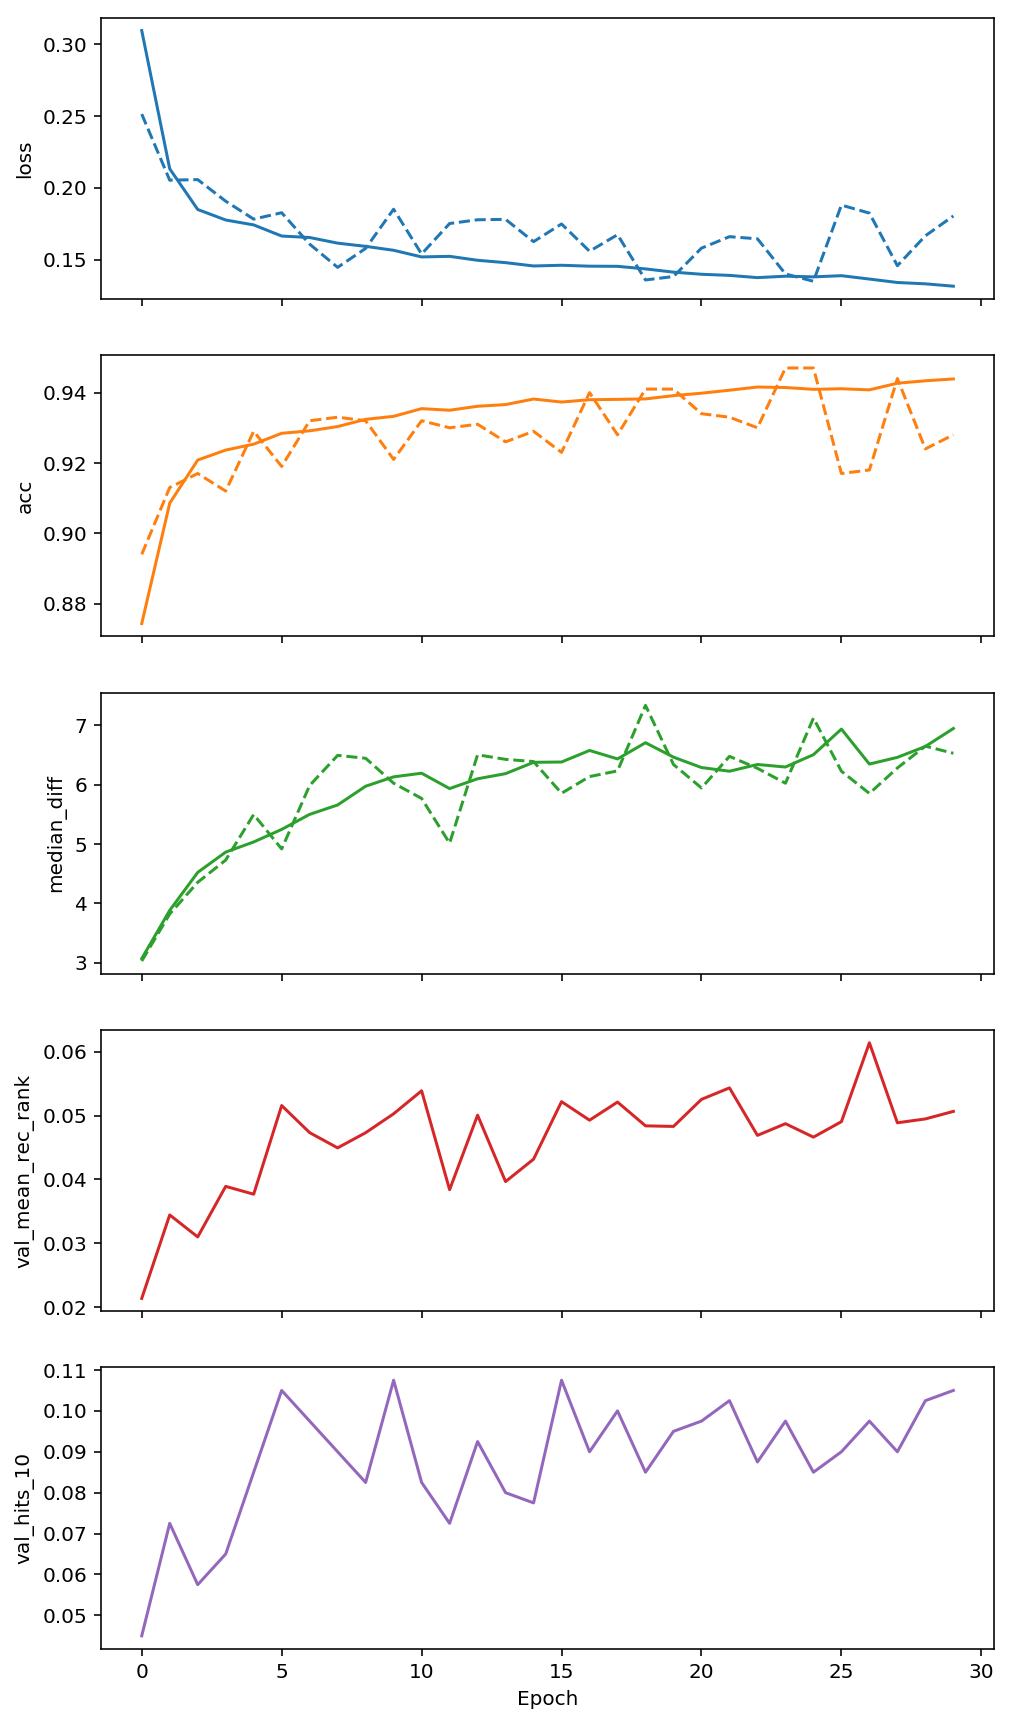

In [276]:
history.plot('loss', 'acc', 'median_diff', 'val_mean_rec_rank', 'val_hits_10', figsize=(8, 15))

In [280]:
with open('history.txt', 'w+') as f:
    for name in history:
        f.write('{} [{}]: {}'.format(name, history.long_names[name], history[name]))
        f.write('\n')

In [291]:
df = pd.DataFrame.from_dict(history)
df = df.rename(columns=lambda name: '{} [{}]'.format(name, history.long_names[name]))
df.to_csv('history.tsv', index=False, sep=str('\t'))

In [313]:
ranker(show_progress=True)

HBox(children=(IntProgress(value=0), HTML(value=u'')))

(341.84, 0.011054482894495421, 0.0, 0.005, 0.015)

In [212]:
def compute_rank(triple, corrupt_object=False, filtered=True):
    
    triples_to_rank = []  # first element is correct triple
    #if filtered:
    #    indices_true_triples = []  # indices of corrupted triples that are actually true (used for filtering)

    # TODO: Could compute this once and store it for all triples in the validation set.
    
    # Add all possible corrupted triples to `triples_to_rank`, note tripels that are actually true.
    for i in tqdm_notebook(range(num_nodes)):
        if corrupt_object:
            corrupted_triple = (triple[0], i, triple[2])
        else:
            corrupted_triple = (i, triple[1], triple[2])

        if corrupted_triple not in triples_list:
            triples_to_rank.append(corrupted_triple)
        # TODO: This part is super slow, speed it up.
        #if filtered and corrupted_triple in triples_list:  # corrupted_triple is actually a true triple
            #print(triples_to_rank)
            #print('Found true triple at index {}: {}'.format(i+1, corrupted_triple))
        #    indices_true_triples.append(i+1)
            

    # Score all triples and find rank of the true triple.
    # TODO: This currently computes node embeddings for all triples two times, and for each test triple.
    #       Could be sped up by computing all node embeddings once and reusing them.
    #print(triples_to_rank)
    #scores = predict(net, triples_to_rank).data.numpy()
#    scores = net(np.asarray(triples_to_rank)).cpu().data.numpy()
    #if filtered:
    #    scores = np.delete(scores, indices_true_triples)
    #print(scores[:5])
#    rank = sp.stats.rankdata(-scores, 'ordinal')[0]  # apply negative so highest score is rank 1
    #reciprocal_rank = rank / len(scores)
    
#    return rank
    

    #if not filtered:
    #    return rank#, reciprocal_rank
    #else:
    #    filtered_scores = np.delete(scores, indices_true_triples)
    #    filtered_rank = sp.stats.rankdata(-filtered_scores, 'ordinal')[0]  # apply negative so highest score is rank 1
        #filtered_reciprocal_rank = filtered_rank / len(filtered_scores)
    #    return rank, filtered_rank#, reciprocal_rank, filtered_rank, filtered_reciprocal_rank

# TODO: This will give slightly different results because the neighborhood is sampled at each run.
#       Maybe aggregate over the complete neighborhood here.
compute_rank(val[0], filtered=True)

HBox(children=(IntProgress(value=0, max=2625), HTML(value=u'')))

Exception in thread Thread-22:
Traceback (most recent call last):
  File "/home/jrieke/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/jrieke/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jrieke/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [222]:
len(triples_to_rank), num_nodes

(744, 2625)

In [255]:
def compute_mean_rank_metrics(triples, filtered=True, show_progress=False):
    if show_progress:
        triples = tqdm_notebook(triples)
    ranks = []
    for triple in triples:
        ranks.append(compute_rank(triple, corrupt_object=False, filtered=filtered))
        ranks.append(compute_rank(triple, corrupt_object=True, filtered=filtered))
    ranks = np.asarray(ranks)
    
    def hits_at(n):
        return np.sum(ranks <= n) / len(ranks)
    
    return np.mean(ranks), np.mean(1 / ranks), hits_at(1), hits_at(3), hits_at(10)
        
    #if not include_filtered:
    #    return np.mean(metrics), np.mean(1 / metrics), hits_at(metrics, 1), hits_at(metrics, 3), hits_at(metrics, 10)
    #else:
    #    return np.mean(metrics[:, 0]), np.mean(1 / metrics[:, 0]), np.mean(metrics[:, 1]), np.mean(1 / metrics[:, 1])

compute_mean_rank_metrics(val[:10], filtered=True)

HBox(children=(IntProgress(value=0, max=2625), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2625), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2625), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2625), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2625), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=2625), HTML(value=u'')))

KeyboardInterrupt: 

In [ ]:
def contains_row(array, row):
    """Check if the 1D row is contained in the 2D array."""
    array = np.asarray(array)
    row = np.asarray(row)
    return (array - row == 0).all(axis=1).any()

print(triples_list[:5])
contains_row(triples_list, (185, 1244, 2))

In [71]:
class RankingEvaluation(object):
    
    def __init__(self, triples, num_nodes, filtered=False, show_progress=False):
        self.triples = triples
        self.num_nodes = num_nodes
        self.filtered = filtered
        
        
        if self.filtered:
            
            # TODO: It seems like this takes way longer for corrupted object (~30s per triple)
            #       than for corrupted subject (~6s per triple). Find out why.
        
            self.true_triples_subject_corrupted_per_triple = []
            self.true_triples_object_corrupted_per_triple = []
        
            for triple in tqdm_notebook(self.triples) if show_progress else self.triples:
                true_triples_subject_corrupted = []
                true_triples_object_corrupted = []
                for i in range(num_nodes):
                    triple_subject_corrupted = (i, triple[1], triple[2])
                    if triple_subject_corrupted in triples_list:
                        true_triples_subject_corrupted.append(i)
                        
                    triple_object_corrupted = (triple[0], i, triple[2])
                    if triple_object_corrupted in triples_list:
                        true_triples_object_corrupted.append(i)

                self.true_triples_subject_corrupted_per_triple.append(true_triples_subject_corrupted)
                self.true_triples_object_corrupted_per_triple.append(true_triples_object_corrupted)
                
        
        # This solution has approximately the same runtime (it's about 10% faster than the solution above with 'in').
        #if False and filtered:
        #    # TODO: Rename.
        #    self.true_triples_subject_corrupted = np.zeros((len(self.triples), self.num_nodes), dtype=bool)
        #    self.true_triples_object_corrupted = np.zeros((len(self.triples), self.num_nodes), dtype=bool)
        #    
        #    for i, triple in enumerate(self.triples):
        #        print('Processing triple', triple)
        #        
        #        triples_subject_corrupted = np.zeros((self.num_nodes, 3))
        #        triples_subject_corrupted[:, 0] = np.arange(num_nodes)
        #        triples_subject_corrupted[:, 1] = triple[1]
        #        triples_subject_corrupted[:, 2] = triple[2]
        #        
        #        for j, corrupted_triple in enumerate(tqdm_notebook(triples_subject_corrupted)):
        #            self.true_triples_subject_corrupted[i, j] = contains_row(triples_list, corrupted_triple)

                #for i in range(self.num_nodes):
                #    corrupted_triple_subject = (i, triple[1], triple[2])
                #    if contains_row(triples_list, corrupted_triple_subject):
                #        true_triples_subject_corrupted.append(i)
                        
                #    corrupted_triple_object = (triple[0], i, triple[2])
                #    if contains_row(triples_list, corrupted_triple_object):
                #        true_triples_object_corrupted.append(i)
                        
                #print('Found', len(true_triples_subject_corrupted), 'subject-corrupted triples that are actually true and', len(true_triples_object_corrupted), 'object-corrupted triples that are actually true')
                        
                #self.true_triples_subject_corrupted_per_triple.append(true_triples_subject_corrupted)
                #self.true_triples_object_corrupted_per_triple.append(true_triples_object_corrupted)
            
            
    def _get_rank(self, scoring_model, subject_embeddings, object_embeddings, relations, n, true_triples=None):
        scores = scoring_model(subject_embeddings, object_embeddings, relations).cpu().data.numpy()
        if self.filtered:
            scores = np.delete(scores, true_triples)
        rank = sp.stats.rankdata(-scores, 'ordinal')[n]  # apply negative so highest score is 
        return rank
    
    
    def __call__(self, embedding_model, scoring_model, verbose=False, show_progress=False):
        
        # TODO: Delete show_progress, it's not needed with the new DistMult module.
        
        all_node_embeddings = embedding_model(np.arange(self.num_nodes))
        ranks = []

        for i, triple in enumerate(tqdm_notebook(self.triples)) if show_progress else enumerate(self.triples):
            #print(triple, ':', end=' ')

            repeated_subject_embedding = all_node_embeddings[triple[0]].expand(self.num_nodes, -1)
            repeated_object_embedding = all_node_embeddings[triple[1]].expand(self.num_nodes, -1)
            repeated_relation = np.repeat(triple[2], self.num_nodes)

            # TODO: Refactor this.
            rank_subject_corrupted = self._get_rank(scoring_model, all_node_embeddings, repeated_object_embedding, repeated_relation, triple[0], self.true_triples_subject_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_subject_corrupted)
            
            rank_object_corrupted = self._get_rank(scoring_model, repeated_subject_embedding, all_node_embeddings, repeated_relation, triple[1], self.true_triples_object_corrupted_per_triple[i] if self.filtered else None)
            ranks.append(rank_object_corrupted)
            
            # TODO: Check if these are more or less the same.
            if verbose: print(rank_subject_corrupted, rank_object_corrupted)
            
        ranks = np.asarray(ranks)
        
        def hits_at(n):
            return np.sum(ranks <= n) / len(ranks)

        return np.mean(ranks), np.mean(1 / ranks), hits_at(1), hits_at(3), hits_at(10)
        
        

In [72]:
ranker2 = RankingEvaluation(val[:10], num_nodes, filtered=False, show_progress=True)

In [37]:
%load_ext line_profiler

In [60]:
%lprun -f ranker2.__call__ ranker2(net.graph_conv2, net.dist_mult, show_progress=True)

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])
torch.Size([2625, 2625])

*** KeyboardInterrupt exception caught in code being profiled.